In [1]:
import torch
import numpy as  np
import tensorflow as tf
import matplotlib.pyplot as plt

import ManageData as MD


2023-11-02 12:54:53.247723: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 12:54:53.278847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [145]:
DataDir = '/remote/tychodata/ftairli/work/Projects/FD_Reconstruction/Data/NormData/'    
Main_train        = torch.load(DataDir + 'Main_train.pt')
GenGeometry_train = torch.load(DataDir + 'GenGeometry_train.pt')
Meta_train        = torch.load(DataDir + 'Meta_train.pt')

Main_train[torch.isfinite(Main_train) == False] = 0

# Geometry : [Chi0,Rp,T0,Phi,Theta]
# Main     : [Channels:22:20]
# Meta     : [logE,Xmax,A1,A2,A3,C1,C2,C3,EyeId,MirrprId]

In [146]:
# Normalize Data_train
Theta = GenGeometry_train[:,4]
# Theta = MD.Theta_to_net(Theta)
# Phi   = GenGeometry_train[:,3]
# Phi   = MD.Phi_to_mirror(Phi,Meta_train[:,9])
# Phi   = MD.Phi_to_net(Phi)

# Theta = Theta.unsqueeze(1).numpy()
# Phi   = Phi.unsqueeze(1).numpy()

dirX = np.cos(Theta)
dirY = np.sin(Theta)

X_train = Main_train.numpy()
Y_train = np.stack((dirX,dirY),axis=1)

print(X_train.shape)
print(Y_train.shape)

(141787, 2, 22, 20)
(141787, 2)


31876


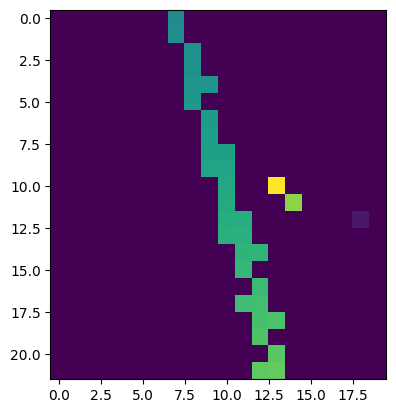

[-0.29010925  0.9569935 ]


In [147]:
i = np.random.randint(0,X_train.shape[0])
print(i)

plt.figure()
plt.imshow(X_train[i,0,:,:])
plt.show()
print(Y_train[i,:])

In [185]:
# Define the model
Input_shape = (2,22,20)
Data_format = 'channels_first'
N_kernels   = 32
N_Nodes     = 128
model = tf.keras.models.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(1,2),data_format=Data_format), # This Returns a 20x20 image after Conv2D
    tf.keras.layers.Conv2D(N_kernels,(5,5),activation='relu',input_shape=Input_shape,data_format=Data_format),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),data_format=Data_format), # Makes 10x10
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(N_Nodes,activation='relu'),
    tf.keras.layers.Dense(1,activation='linear')
    ])



In [205]:
# Do the Training
batch_size = 128

if False: # From scratch
    model.compile(optimizer='adam',loss='mse')
if True: # Reduce Learning Rate 
    newLR = tf.keras.backend.get_value(model.optimizer.learning_rate)*0.1
    tf.keras.backend.set_value(model.optimizer.learning_rate,newLR)

model.fit(X_train,Y_train[:,0],epochs=10,batch_size=batch_size)

Epoch 1/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 2/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 3/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 4/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 5/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 6/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 7/10
1108/1108 [==============================] - 6s 5ms/step - loss: 0.0031
Epoch 8/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 9/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 10/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031


In [206]:
# Load the Test Data
Main_test        = torch.load(DataDir + 'Main_test.pt')
GenGeometry_test = torch.load(DataDir + 'GenGeometry_test.pt')
Meta_test        = torch.load(DataDir + 'Meta_test.pt')

Main_test[torch.isfinite(Main_test) == False] = 0

# Normalize Data_test
Theta = GenGeometry_test[:,4]
# Theta = MD.Theta_to_net(Theta)
# Phi   = GenGeometry_test[:,3]
# Phi   = MD.Phi_to_mirror(Phi,Meta_test[:,9])
# Phi   = MD.Phi_to_net(Phi)

# Theta = Theta.unsqueeze(1).numpy()
# Phi   = Phi.unsqueeze(1).numpy()
dirX = np.cos(Theta)
dirY = np.sin(Theta)

X_test = Main_test.numpy()
Y_test = np.stack((dirX,dirY),axis=1)

print(X_test.shape)
print(Y_test.shape)

(17724, 2, 22, 20)
(17724, 2)


In [207]:
# Conduct the Test Here
Y_pred = model.predict(X_test,batch_size=batch_size)

# Unnormalise Data

# Y_pred[:,0] = MD.Theta_to_val(Y_pred[:,0])
# Y_pred[:,1] = MD.Phi_to_val(Y_pred[:,1])

# Y_test[:,0] = MD.Theta_to_val(Y_test[:,0])
# Y_test[:,1] = MD.Phi_to_val(Y_test[:,1])




139/139 [==============================] - 0s 3ms/step


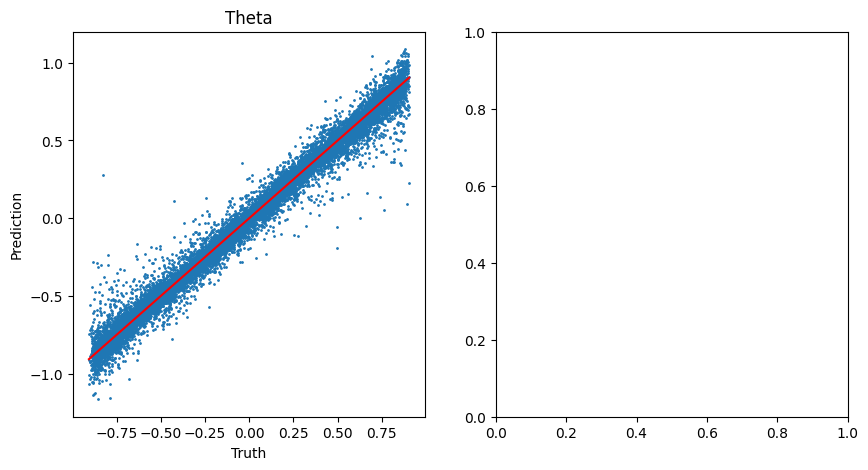

0.0044608284


In [209]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(Y_test[:,0],Y_pred[:,0],s=1)
ax[0].plot([min(Y_test[:,0]),max(Y_test[:,0])],[min(Y_test[:,0]),max(Y_test[:,0])],'r')
ax[0].set_xlabel('Truth')
ax[0].set_ylabel('Prediction')
ax[0].set_title('Theta')
# ax[1].scatter(Y_test[:,1],Y_pred[:,1],s=1)
# ax[1].plot([min(Y_test[:,1]),max(Y_test[:,1])],[min(Y_test[:,1]),max(Y_test[:,1])],'r')
# ax[1].set_xlabel('Truth')
# ax[1].set_ylabel('Prediction')
# ax[1].set_title('Phi')
plt.show()

print(np.mean((Y_test[:,0]-Y_pred[:,0])**2))

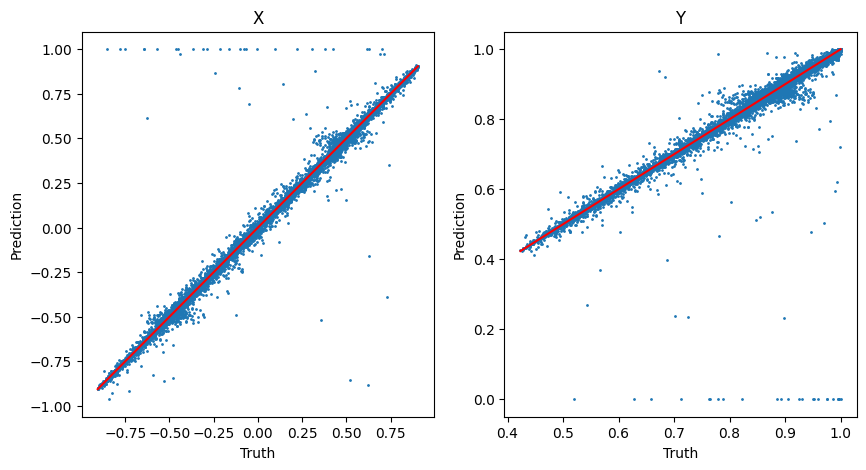

0.0033382268


In [210]:
# Test against regula reconstruction

RecGeometry_test = torch.load(DataDir + 'RecGeometry_test.pt')
RecGeometry_test = RecGeometry_test.numpy()

Theta = RecGeometry_test[:,4]

dirX = np.cos(Theta)
dirY = np.sin(Theta)

R_test = np.stack((dirX,dirY),axis=1)

# fig,ax = plt.subplots(1,2,figsize=(10,5))

# Plot the results
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(Y_test[:,0],R_test[:,0],s=1)
ax[0].plot([min(Y_test[:,0]),max(Y_test[:,0])],[min(Y_test[:,0]),max(Y_test[:,0])],'r')
ax[0].set_xlabel('Truth')
ax[0].set_ylabel('Prediction')
ax[0].set_title('X')
ax[1].scatter(Y_test[:,1],R_test[:,1],s=1)
ax[1].plot([min(Y_test[:,1]),max(Y_test[:,1])],[min(Y_test[:,1]),max(Y_test[:,1])],'r')
ax[1].set_xlabel('Truth')
ax[1].set_ylabel('Prediction')
ax[1].set_title('Y')
plt.show()
print(np.mean((Y_test[:,0]-R_test[:,0])**2))